In [1]:
# Google Colab Only
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval maite-datasets
    !export LC_ALL="en_US.UTF-8"
    !export LD_LIBRARY_PATH="/usr/lib64-nvidia"
    !export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
    !ldconfig /usr/lib64-nvidia
except Exception:
    pass

%pip install -q tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from collections.abc import Sequence
from typing import Any, cast

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from maite_datasets.image_classification import MNIST
from numpy.typing import NDArray
from tabulate import tabulate
from torch.utils.data import DataLoader, Subset
from torch.utils.data import Dataset as TorchDataset

from dataeval import config
from dataeval.data import Select
from dataeval.data.selections import Limit
from dataeval.protocols import Dataset, DatumMetadata
from dataeval.workflows import Sufficiency, SufficiencyConfig

DatumType = tuple[NDArray[np.number[Any]], NDArray[np.number[Any]], DatumMetadata]

# Set seed for reproducibility
config.set_seed(0)

# Set hardware based on system
device = "cuda" if torch.cuda.is_available() else "cpu"
config.set_device(device=device)

# Additional reproducibility and printing options
np.set_printoptions(formatter={"float": lambda x: f"{x:0.4f}"})
torch.set_float32_matmul_precision("high")
torch._dynamo.config.suppress_errors = True
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [3]:
# Configure the dataset transforms

transforms = [
    lambda x: x / 255.0,  # scale to [0, 1]
    lambda x: x.astype(np.float32),  # convert to float32
]

# Download the mnist dataset and apply the transforms and subset the data
train_ds = Select(MNIST(root="./data", image_set="train", transforms=transforms,download=True),selections=[Limit(2500)])  # fmt: skip # noqa: E501
test_ds = Select(MNIST(root="./data", image_set="test", transforms=transforms, download=True), selections=[Limit(500)])

In [4]:
# Define our network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(6400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Compile the model (cast sets the type to Net as compile returns an Unknown)
model: Net = cast(Net, torch.compile(Net().to(device)))

In [5]:
class MNISTTrainingStrategy:
    def train(self, model: nn.Module, dataset: Dataset[DatumType], indices: Sequence[int]):
        # Defined only for this testing scenario
        criterion = torch.nn.CrossEntropyLoss().to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        epochs = 10

        # Define the dataloader for training
        dataloader = DataLoader(Subset(cast(TorchDataset, dataset), indices), batch_size=8)

        for epoch in range(epochs):
            for batch in dataloader:
                # Load data/images to device
                X = torch.Tensor(batch[0]).to(device)
                # Load one-hot encoded targets/labels to device
                y = torch.argmax(torch.asarray(batch[1], dtype=torch.int).to(device), dim=1)
                # Zero out gradients
                optimizer.zero_grad()
                # Forward propagation
                outputs = model(X)
                # Compute loss
                loss = criterion(outputs, y)
                # Back prop
                loss.backward()
                # Update weights/parameters
                optimizer.step()

In [6]:
class MNISTEvaluationStrategy:
    def evaluate(self, model: nn.Module, dataset: Dataset[DatumType]) -> dict[str, float]:
        # Metrics of interest
        metrics = {
            "Accuracy": torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device),
            "AUROC": torchmetrics.AUROC(task="multiclass", num_classes=10).to(device),
            "TPR at 0.5 Fixed FPR": torchmetrics.ROC(task="multiclass", average="macro", num_classes=10).to(device),
        }
        result = {}
        # Set model layers into evaluation mode
        model.eval()
        dataloader = DataLoader(cast(TorchDataset, dataset), batch_size=8)
        # Tell PyTorch to not track gradients, greatly speeds up processing
        with torch.no_grad():
            for batch in dataloader:
                # Load data/images to device
                X = torch.Tensor(batch[0]).to(device)
                # Load one-hot encoded targets/labels to device
                y = torch.argmax(torch.asarray(batch[1], dtype=torch.int).to(device), dim=1)
                preds = model(X)
                for metric in metrics.values():
                    metric.update(preds, y)
            # Compute ROC curve
            false_positive_rate, true_positive_rate, _ = metrics["TPR at 0.5 Fixed FPR"].compute()
            # determine interval to examine
            desired_rate = 0.5
            closest_desired_index = torch.argmin(torch.abs(false_positive_rate - desired_rate)).item()
            # return corresponding tpr value
            result["TPR at 0.5 Fixed FPR"] = true_positive_rate[closest_desired_index].cpu()
            result["Accuracy"] = metrics["Accuracy"].compute().cpu()
            result["AUROC"] = metrics["AUROC"].compute().cpu()
        return result

In [7]:
mnist_config = SufficiencyConfig(
    training_strategy=MNISTTrainingStrategy(),
    evaluation_strategy=MNISTEvaluationStrategy(),
    runs=5,
    substeps=10,
)

In [8]:
# Instantiate sufficiency metric
suff = Sufficiency(
    model=model,
    train_ds=train_ds,
    test_ds=test_ds,
    config=mnist_config,
)

In [9]:
# Train & test model
output = suff.evaluate()

In [10]:
# Print out sufficiency output in a table format
formatted = {"Steps": output.steps, **output.averaged_measures}
print(tabulate(formatted, headers=list(formatted), tablefmt="pretty"))

+-------+----------------------+---------------------+--------------------+
| Steps | TPR at 0.5 Fixed FPR |      Accuracy       |       AUROC        |
+-------+----------------------+---------------------+--------------------+
|  25   |  0.7599895596504211  | 0.17760000079870225 | 0.715382206439972  |
|  41   |  0.9388901710510253  |  0.48960000872612   | 0.8840733051300049 |
|  69   |  0.9635285139083862  | 0.6688000082969665  | 0.9260659694671631 |
|  116  |  0.983984649181366   |  0.754799997806549  | 0.9555106520652771 |
|  193  |  0.9816735029220581  | 0.7848000049591064  | 0.9607900619506836 |
|  322  |  0.9931752920150757  | 0.8391999840736389  | 0.9791258811950684 |
|  538  |  0.9986919283866882  | 0.8848000049591065  | 0.9877924799919129 |
|  898  |         1.0          | 0.8991999983787536  | 0.9916555643081665 |
| 1498  |  0.999147379398346   | 0.9192000031471252  | 0.9936585068702698 |
| 2500  |  0.9991000056266784  | 0.9348000168800354  | 0.995325231552124  |
+-------+---

In [11]:
# Print out projected output values
projection = output.project([1000, 2500, 5000])
projected = {"Steps": projection.steps, **projection.averaged_measures}
print(tabulate(projected, list(projected), tablefmt="pretty"))

+-------+----------------------+--------------------+--------------------+
| Steps | TPR at 0.5 Fixed FPR |      Accuracy      |       AUROC        |
+-------+----------------------+--------------------+--------------------+
| 1000  |  0.993626858667088   | 0.9012382245791293 | 0.9863057281693617 |
| 2500  |  0.9936407019841024  | 0.9131581944071436 | 0.9868693096735072 |
| 5000  |  0.9936418665972934  | 0.917222738882075  | 0.9869828111627149 |
+-------+----------------------+--------------------+--------------------+


In [12]:
### TEST ASSERTION CELL ###
for name, values in output.averaged_measures.items():
    assert abs(values[-1] - projection.averaged_measures[name][-2]) < 0.025

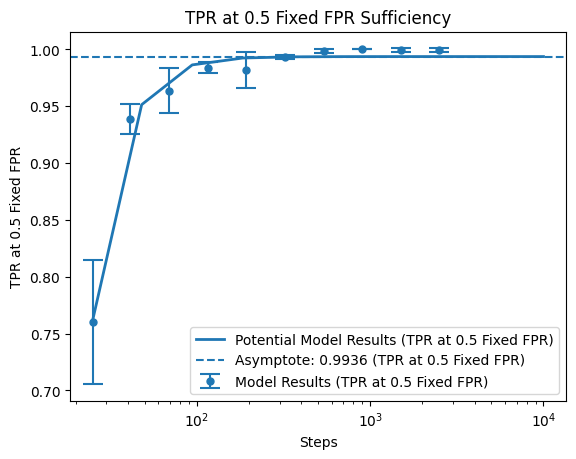

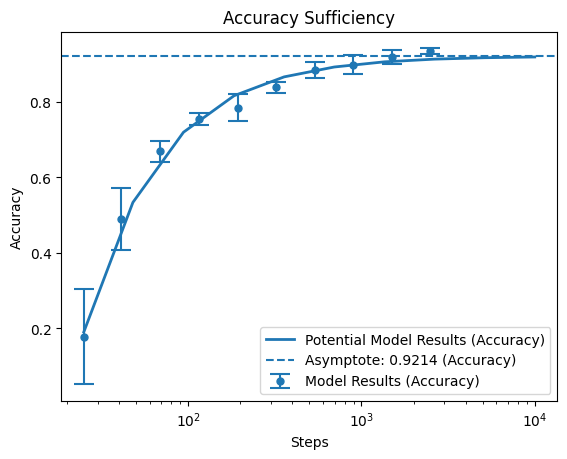

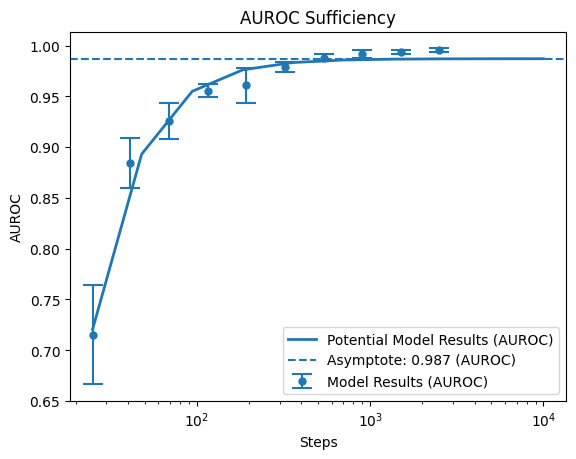

In [13]:
# Plot the output using the convenience function
_ = output.plot()

In [14]:
# Initialize the array of desired thresholds to apply to all metrics
desired_values = np.array([0.90, 0.93, 0.99])
metrics = ["Accuracy", "AUROC", "TPR at 0.5 Fixed FPR"]
evaluated_metrics = {}

for metric in metrics:
    evaluated_metrics[metric] = desired_values
# Evaluate the learning curve to infer the needed amount of training data
samples_needed = output.inv_project(evaluated_metrics)

/workspaces/dataeval/src/dataeval/outputs/_workflows.py:247: UserWarning: Number of samples could not be determined for target(s): [0.93, 0.99] with asymptote of 0.9214451757000093
  warnings.warn(
/workspaces/dataeval/src/dataeval/outputs/_workflows.py:247: UserWarning: Number of samples could not be determined for target(s): [0.99] with asymptote of 0.9870387802499436
  warnings.warn(


In [15]:
# Print the amount of needed data needed to achieve the thresholds
for metric, samples in samples_needed.items():
    print(f"{metric}")
    for index, sample_size in enumerate(samples):
        print(
            f"To achieve {int(evaluated_metrics[metric][index] * 100)}% {metric},"
            f" {int(sample_size)} samples are needed."
        )
    print()

Accuracy
To achieve 90% Accuracy, 940 samples are needed.
To achieve 93% Accuracy, -1 samples are needed.
To achieve 99% Accuracy, -1 samples are needed.

AUROC
To achieve 90% AUROC, 50 samples are needed.
To achieve 93% AUROC, 65 samples are needed.
To achieve 99% AUROC, -1 samples are needed.

TPR at 0.5 Fixed FPR
To achieve 90% TPR at 0.5 Fixed FPR, 35 samples are needed.
To achieve 93% TPR at 0.5 Fixed FPR, 41 samples are needed.
To achieve 99% TPR at 0.5 Fixed FPR, 122 samples are needed.

